In [157]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import datetime
import re
from scipy.sparse import find

In [2]:
# Not sure all of these are needed
from tokenizers import Tokenizer
from tokenizers.models import BPE
from sklearn.feature_extraction.text import CountVectorizer

### Read SILVA data

In [3]:
# Heavy file, takes a minute
silva_db = pd.read_table('C:/Users/efrat/Downloads/silva_138_release/Exports/SILVA_parsed_V2.tsv', index_col = 0,
                        dtype={'raw_id': str, 
                               "full_taxonomy": str, 
                               "seq_length": int,
                               "seq": str, 
                               "kingdom": str, 
                               "phylum": str, 
                               "class": str, 
                               "order": str, 
                               "family": str,
                               "genus": str,
                               "species": str,
                               "strain": str})
silva_db.head()

,raw_id,full_taxonomy,seq_length,seq,kingdom,phylum,class,order,family,genus,species,strain
0,HG531388.1.1375,Bacteria;Proteobacteria;Alphaproteobacteria;Rh...,1375,AGUCGAGCGGGCGCAGCAAUGCGUCAGCGGCAGACGGGUGAGUAAC...,Bacteria,Proteobacteria,Alphaproteobacteria,Rhizobiales,Xanthobacteraceae,Rhodoplanes,Rhodoplanes oryzae,NaN
1,HL281785.3.1301,Bacteria;Bacteroidota;Bacteroidia;Bacteroidale...,1299,AUUCCGGGAUAGCCUUUCGAAAGAAAGAUUAAUACUGGAUAGCAUA...,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,unidentified,NaN
2,AB002644.1.1485,Bacteria;Firmicutes;Bacilli;Bacillales;Bacilla...,1485,GGCUAAUACAUGCAAGUCGAGCGAGUGAACAAACAGAAGCCUUCGG...,Bacteria,Firmicutes,Bacilli,Bacillales,Bacillaceae,Bacillus,low G+C Gram-positive bacterium HTA454,NaN
3,AB002648.1.1383,Bacteria;Firmicutes;Bacilli;Thermoactinomyceta...,1383,AGCGGCGAACGGGUGAGUAACACGNGGGUAACCUGCCCUCAAGACC...,Bacteria,Firmicutes,Bacilli,Thermoactinomycetales,Thermoactinomycetaceae,Thermoflavimicrobium,low G+C Gram-positive bacterium HTA1422,NaN
4,JN049459.1.1443,Bacteria;Actinobacteriota;Actinobacteria;Strep...,1443,GACAUGGCGCCUCUACCAUGCAGUCGACGAUGACCACCUUCGGGGU...,Bacteria,Actinobacteriota,Actinobacteria,Streptomycetales,Streptomycetaceae,Streptomyces,actinobacterium ZXY010,NaN


In [4]:
# Create list of all sequences in our data and convert to lowercase
seqs = silva_db.seq.values
seqs = [s.lower() for s in seqs]
#seqs[0:2]
print(len(seqs),"sequences total in db")

432033 sequences total in db


### Read BPE tokens

In [5]:
# Load the BPE tokenizer
vocab = "C:/Users/efrat/Documents/DNA_BERT_Data/tokens/vocab_15K/vocab.json"
merges = "C:/Users/efrat/Documents/DNA_BERT_Data/tokens/vocab_15K/merges.txt"
tokenizer_15K = Tokenizer(BPE())
tokenizer_15K.model = BPE(vocab, merges)
vocab_dict = json.load(open(vocab))

### Get k-mer tokens

In [6]:
# Helper functions
# Given a sequence and k-length, return the unique set of k-mers
def get_kmers_seq(seq, k):
    # Start with an empty set
    kmers = set()
    # Calculate how many kmers of length k there are
    num_kmers = len(seq) - k + 1
    # Loop over the kmer start positions
    for i in range(num_kmers):
        # Slice the string to get the kmer
        kmer = seq[i:i+k]
        # Add the kmer to the dictionary if it's not there
        kmers.add(kmer)
    # Return the final counts
    return kmers

def get_kmers(seqs, k):
    kmers = set()
    n = len(seqs)
    i = 0
    for seq in seqs:
        i += 1
        if i%1000 == 0:
            print(".", end=' ')
        kmers = kmers.union(get_kmers_seq(seq, k))
    return kmers
    
def encode_kmers(seq, k):
    kmer_encoding = []
    num_kmers = len(seq) - k + 1
    for i in range(num_kmers):
        kmer = seq[i:i+k]
        kmer_encoding.append(kmer)
    return kmer_encoding

In [7]:
# Here we calculate the actual vocab' size per k = 8/10/12
#kmer_vocab_8 = get_kmers(seqs, 8)
#print("8-mer vocab size:", len(kmer_vocab_8)) # --> 259339
#kmer_vocab_10 = get_kmers(seqs, 10)
#print("10-mer vocab size:", len(kmer_vocab_10)) # --> 1611004
#kmer_vocab_6 = get_kmers(seqs, 6)
#print("6-mer vocab size:", len(kmer_vocab_6)) # --> 15621
#kmer_vocab_4 = get_kmers(seqs, 4)
#print("4-mer vocab size:", len(kmer_vocab_4)) # --> 625

### Create a matrix of tokens-in-sequences
The matrix (all_encodings_cv) will be sparse. 

In [8]:
# Use sklearn to batch encode all sequences and convert to a matrix (takes a few minutes)
print(datetime.datetime.now())
cv = CountVectorizer(tokenizer = lambda x: tokenizer_15K.encode(x).tokens, lowercase = True)
all_encodings_cv_bpe = cv.fit_transform(seqs)
token_strings_bpe = cv.get_feature_names()
print(all_encodings_cv_bpe.shape)
print(datetime.datetime.now())

2020-07-19 10:04:55.990637
(432033, 15620)
2020-07-19 10:13:36.145018


Same for kmer-based tokens

In [9]:
print(datetime.datetime.now())
cv_6mer = CountVectorizer(tokenizer = lambda x: encode_kmers(x, 6), lowercase = True)
all_encodings_cv_6mer = cv_6mer.fit_transform(seqs)
token_strings_6mer = cv_6mer.get_feature_names()
print(all_encodings_cv_6mer.shape)
print(datetime.datetime.now())

2020-07-19 10:13:36.152964
(432033, 15621)
2020-07-19 10:20:11.005341


## Tokens analysis

Per token, we collect the following statistics:
* token + token id (identifiers)
* token_length
* total_num_of_appearances

And for each taxonomic level ('phylum','class','order','family','genus','species','strain'):
* token_id
* tax_level 
* tax_name
* num_appearances

These will help us understand which tokens are widely shared (and not short, so not trivial) and which are clade specific.

### Collect statistics

Helper functions

In [20]:
# For each token, get its total count of appearances (a token may appear multiple times in a single sequence)
def get_token_appearances(encodings_cv):
    token_appearances = encodings_cv.sum(0).tolist()
    token_appearances = [i for sublist in token_appearances for i in sublist]
    return token_appearances

# For each token, get the number of unique sequences it appears in 
def get_token_appearances_uniq(encodings_cv):
    token_appearances_uniq = (encodings_cv != 0).sum(0).tolist()
    token_appearances_uniq = [i for sublist in token_appearances_uniq for i in sublist]
    return token_appearances_uniq

# For each token, collect clade-specific stats
# (Currently takes several minutes)
def get_clade_spec_stats(encodings_cv, column_names, calc_stats_flags, silva_db):
    nseqs = encodings_cv.shape[0]
    # Init' empty dataset
    token_taxon_stats = pd.DataFrame(columns=['token','tax_level','tax_name','n_occurrences']) 

    # Iterate over tokens, only if flag calc_stats_flags = True
    for i in range(0, len(column_names)):
        if i%100 == 0: print('.', end = '')
        if i%5000 == 0: print("Completed",i,"/",len(column_names),"tokens")
        if not calc_stats_flags[i]: continue
        current_token = column_names[i]
        seq_appearances_vec = encodings_cv.getcol(i)
        seq_appearances_vec = [j[0] for j in seq_appearances_vec.toarray()] # flatten
        # Get indices of relevant sequences
        seqs_ids = [j for j, val in enumerate(seq_appearances_vec) if val == 1] 
        # Get metadata rows for the sequences in above indices
        db_subset = silva_db.loc[seqs_ids, ]

        # Iterate over taxonomic levels to get level-specific stats
        for tax_level in ['phylum','class','order','family','genus','species','strain']:
            level_counts = db_subset.groupby(tax_level, as_index = False).agg({'raw_id':'count'})
            level_counts = level_counts[level_counts['raw_id'] > 4] # We remove entities with only few hits, to reduce noise
            level_counts.columns = ['tax_name', 'n_occurrences']
            level_counts['tax_level'] = tax_level
            level_counts['token'] = current_token
            #print(level_counts.head())
            token_taxon_stats = token_taxon_stats.append(level_counts)

    return token_taxon_stats

In [11]:
# Analyze bpe tokens (appearances stats)
bpe_token_appearances = get_token_appearances(all_encodings_cv_bpe)
# Sanity (should be same size as vocab size)
print(len(bpe_token_appearances))

bpe_token_appearances_uniq = get_token_appearances_uniq(all_encodings_cv_bpe)
# Sanity (should be same size as vocab size)
print(len(bpe_token_appearances_uniq))

15620
15620


In [12]:
# Analyze k-mer tokens (appearances stats)
kmer_token_appearances = get_token_appearances(all_encodings_cv_6mer)
# Sanity (should be same size as vocab size)
print(len(kmer_token_appearances))

kmer_token_appearances_uniq = get_token_appearances_uniq(all_encodings_cv_6mer)
# Sanity (should be same size as vocab size)
print(len(kmer_token_appearances_uniq))

15621
15621


In [13]:
# Organize stats into a single data frame - BPE
token_ids = [vocab_dict[t] for t in token_strings_bpe]
token_lengths = [len(t) for t in token_strings_bpe]
token_stats_bpe = pd.DataFrame(list(zip(token_strings_bpe, 
                                    token_ids,
                                    token_lengths, 
                                    bpe_token_appearances, 
                                    bpe_token_appearances_uniq)), 
                           columns =['token', 'token_id', 'token_length', 'total_appearances_mult_in_seq', 'total_seqs_in']) 
token_stats_bpe.head(10)

,token,token_id,token_length,total_appearances_mult_in_seq,total_seqs_in
0,a,0,1,20740,20626
1,aa,6,2,82693,72322
2,aaaa,326,4,49389,42937
3,aaaaac,4433,6,4242,4165
4,aaaaagc,4996,7,2373,2371
5,aaaaagg,9724,7,1528,1517
6,aaaaagu,11317,7,1253,1222
7,aaaaau,6347,6,2642,2635
8,aaaaaugacgguac,8190,14,1899,1899
9,aaaacagg,8369,8,1846,1843


In [33]:
# Same for k-mer
token_stats_6mer = pd.DataFrame(list(zip(token_strings_6mer, kmer_token_appearances, kmer_token_appearances_uniq)), 
                           columns =['token', 'total_appearances_mult_in_seq', 'total_seqs_in']) 
token_stats_6mer.head(10)

,token,total_appearances_mult_in_seq,total_seqs_in
0,aaaaaa,52262,38457
1,aaaaac,95941,89694
2,aaaaag,107978,97615
3,aaaaan,91,91
4,aaaaau,41319,38144
5,aaaaca,29827,27517
6,aaaacc,152322,130079
7,aaaacg,45603,39375
8,aaaacn,75,75
9,aaaacu,358216,289497


In [36]:
# We next want to collect stats about whether each token is clade-specific or not. 
# Optionally, to reduce runtime / focus on main tokens, we can calculate this for tokens with > 10 apearences only
print("For the BPE vocab, clade-specificity stats will be collected for",
      len(token_stats_bpe[token_stats_bpe.total_seqs_in >= 10]),
      "tokens instead of",len(token_stats_bpe))
print("For the k-mer vocab, clade-specificity stats will be collected for",
      len(token_stats_6mer[token_stats_6mer.total_seqs_in >= 10]),
      "tokens instead of",len(token_stats_6mer))

include_token_bpe = list(token_stats_bpe.total_seqs_in >= 10)
include_token_6mer = list(token_stats_6mer.total_seqs_in >= 10)

For the BPE vocab, clade-specificity stats will be collected for 15603 tokens instead of 15620
For the k-mer vocab, clade-specificity stats will be collected for 14325 tokens instead of 15621


In [18]:
# For each token, collect clade-specific stats
token_taxon_stats_bpe = get_clade_spec_stats(all_encodings_cv_bpe, token_strings_bpe, include_token_bpe, silva_db)

.Completed 0 / 15620 tokens
....................................................................................................Completed 10000 / 15620 tokens
........................................................

In [37]:
token_taxon_stats_6mer = get_clade_spec_stats(all_encodings_cv_6mer, token_strings_6mer, include_token_6mer, silva_db)

.Completed 0 / 15621 tokens
..................................................Completed 5000 / 15621 tokens
..................................................Completed 10000 / 15621 tokens
..................................................Completed 15000 / 15621 tokens
......

In [39]:
# Save to file
token_taxon_stats_bpe.to_csv(path_or_buf = "C:/Users/efrat/Documents/DNA_BERT_Data/tokens/tokens_15K_tax_level_specific_stats.tsv", sep='\t')

In [40]:
token_taxon_stats_6mer.to_csv(path_or_buf = "C:/Users/efrat/Documents/DNA_BERT_Data/tokens/tokens_6mers_tax_level_specific_stats.tsv", sep='\t')

To label tokens as clade-specific, we apply the following logic, per taxonomic level (e.g. phyla):
- for each clade (e.g. each phylum) we count the number of sequences in that clade in which the token appeared (once or more)
- if more than 99% of the sequences containing the token belong to a single clade, we call the taxon clade-specific (we allow 3% for other clades to account for the noisy nature of the data, and the expected annotation mistakes).

In [41]:
def get_summarized_token_taxon_stats(token_stats, token_taxon_stats):
    # We'll take the max count per clade
    token_taxon_sum = token_taxon_stats.groupby(['token', 'tax_level'], as_index = False).agg({'n_occurrences':'max'})
    token_taxon_sum.columns = ['token', 'tax_level', 'max_occurrences_specific_clade']

    # Re-organize the table
    token_taxon_sum = token_taxon_sum.pivot_table(index=['token'], 
                                                  columns='tax_level', 
                                                  values='max_occurrences_specific_clade').reset_index()
    token_taxon_sum.columns = [c if c=="token" else "max_in_single_"+c for c in token_taxon_sum.columns]

    # Merge with the other stats
    token_stats2 = pd.merge(token_stats, token_taxon_sum, on='token')

    # And now we compute the max % of appearances in a single clade
    token_stats2['max_perc_in_single_class'] = token_stats2['max_in_single_class'] * 100.0 / token_stats2['total_seqs_in']
    token_stats2['max_perc_in_single_family'] = token_stats2['max_in_single_family'] * 100.0 / token_stats2['total_seqs_in']
    token_stats2['max_perc_in_single_genus'] = token_stats2['max_in_single_genus'] * 100.0 / token_stats2['total_seqs_in']
    token_stats2['max_perc_in_single_species'] = token_stats2['max_in_single_species'] * 100.0 / token_stats2['total_seqs_in']
    token_stats2['max_perc_in_single_phylum'] = token_stats2['max_in_single_phylum'] * 100.0 / token_stats2['total_seqs_in']
    token_stats2['max_perc_in_single_order'] = token_stats2['max_in_single_order'] * 100.0 / token_stats2['total_seqs_in']
    token_stats2['max_perc_in_single_strain'] = token_stats2['max_in_single_strain'] * 100.0 / token_stats2['total_seqs_in']

    # And label each token as clade-specific or not...
    token_stats2['clade_specific_class'] = token_stats2['max_perc_in_single_class'] > 99
    token_stats2['clade_specific_family'] = token_stats2['max_perc_in_single_family'] > 99
    token_stats2['clade_specific_genus'] = token_stats2['max_perc_in_single_genus'] > 99
    token_stats2['clade_specific_species'] = token_stats2['max_perc_in_single_species'] > 99
    token_stats2['clade_specific_phylum'] = token_stats2['max_perc_in_single_phylum'] > 99
    token_stats2['clade_specific_order'] = token_stats2['max_perc_in_single_order'] > 99
    token_stats2['clade_specific_strain'] = token_stats2['max_perc_in_single_strain'] > 99

    token_stats2['clade_specific_any'] = (token_stats2['clade_specific_strain'] | 
                token_stats2['clade_specific_species'] |
                token_stats2['clade_specific_genus'] |
                token_stats2['clade_specific_family'] |
                token_stats2['clade_specific_order'] |
                token_stats2['clade_specific_class'] |
                token_stats2['clade_specific_phylum'])

    # One additional statistic
    token_stats2['avg_occur_in_seq'] = token_stats2['total_appearances_mult_in_seq'] / token_stats2['total_seqs_in']
    
    return(token_stats2)

In [42]:
# Summarize - BPE stats 
token_stats_bpe2 = get_summarized_token_taxon_stats(token_stats_bpe, token_taxon_stats_bpe)

# Save
token_stats_bpe2.to_csv(path_or_buf = "C:/Users/efrat/Documents/DNA_BERT_Data/tokens/tokens_15K_tax_level_summarized_stats.tsv", sep='\t')
token_stats_bpe2.head(10)

,token,token_id,token_length,total_appearances_mult_in_seq,total_seqs_in,max_in_single_class,max_in_single_family,max_in_single_genus,max_in_single_order,max_in_single_phylum,...,max_perc_in_single_strain,clade_specific_class,clade_specific_family,clade_specific_genus,clade_specific_species,clade_specific_phylum,clade_specific_order,clade_specific_strain,clade_specific_any,avg_occur_in_seq
0,a,0,1,20740,20626,3741.0,1399.0,1554.0,1524.0,6348.0,...,NaN,False,False,False,False,False,False,False,False,1.005527
1,aa,6,2,82693,72322,9796.0,3390.0,4973.0,3358.0,18807.0,...,NaN,False,False,False,False,False,False,False,False,1.143400
2,aaaa,326,4,49389,42937,6057.0,2134.0,3164.0,2415.0,13196.0,...,NaN,False,False,False,False,False,False,False,False,1.150267
3,aaaaac,4433,6,4242,4165,1319.0,465.0,305.0,468.0,2370.0,...,NaN,False,False,False,False,False,False,False,False,1.018487
4,aaaaagc,4996,7,2373,2371,404.0,188.0,218.0,205.0,918.0,...,NaN,False,False,False,False,False,False,False,False,1.000844
5,aaaaagg,9724,7,1528,1517,612.0,497.0,323.0,497.0,777.0,...,NaN,False,False,False,False,False,False,False,False,1.007251
6,aaaaagu,11317,7,1253,1222,228.0,138.0,133.0,179.0,371.0,...,NaN,False,False,False,False,False,False,False,False,1.025368
7,aaaaau,6347,6,2642,2635,1544.0,857.0,489.0,858.0,1615.0,...,NaN,False,False,False,False,False,False,False,False,1.002657
8,aaaaaugacgguac,8190,14,1899,1899,819.0,431.0,422.0,453.0,1036.0,...,NaN,False,False,False,False,False,False,False,False,1.000000
9,aaaacagg,8369,8,1846,1843,1029.0,314.0,283.0,533.0,1052.0,...,NaN,False,False,False,False,False,False,False,False,1.001628


In [43]:
token_stats_bpe2[token_stats_bpe2['clade_specific_any']]

,token,token_id,token_length,total_appearances_mult_in_seq,total_seqs_in,max_in_single_class,max_in_single_family,max_in_single_genus,max_in_single_order,max_in_single_phylum,...,max_perc_in_single_strain,clade_specific_class,clade_specific_family,clade_specific_genus,clade_specific_species,clade_specific_phylum,clade_specific_order,clade_specific_strain,clade_specific_any,avg_occur_in_seq
17,aaaacucuguuauuagggaagaa,4083,23,701,701,700.0,692.0,692.0,692.0,700.0,...,NaN,True,False,False,False,True,False,False,True,1.0
18,aaaacucuguugu,1747,13,2224,2224,2143.0,837.0,794.0,1074.0,2210.0,...,NaN,False,False,False,False,True,False,False,True,1.0
19,aaaacucuguuguuagggaagaacaa,3112,26,471,471,471.0,306.0,251.0,307.0,471.0,...,NaN,True,False,False,False,True,False,False,True,1.0
22,aaaacuguccagcuagagu,11242,19,95,95,95.0,93.0,93.0,93.0,95.0,...,NaN,True,False,False,False,True,False,False,True,1.0
23,aaaacuugagugcagaagagg,3890,21,339,339,339.0,285.0,285.0,286.0,339.0,...,NaN,True,False,False,False,True,False,False,True,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15574,uuuuaacuaccgggcuagagugugucagagggagguggaauuccgc...,10342,114,231,231,231.0,231.0,171.0,231.0,231.0,...,NaN,True,True,False,False,True,True,False,True,1.0
15576,uuuuagaggaugau,8338,14,198,198,188.0,186.0,68.0,186.0,197.0,...,NaN,False,False,False,False,True,False,False,True,1.0
15591,uuuuggauggucccgcggcgu,14451,21,22,22,22.0,22.0,22.0,22.0,22.0,...,NaN,True,True,True,False,True,True,False,True,1.0
15592,uuuuggauggucccgcggcguauuagcuagau,14729,32,57,57,57.0,57.0,57.0,57.0,57.0,...,NaN,True,True,True,False,True,True,False,True,1.0


In [47]:
print("There are", 
      len(token_stats_bpe2[token_stats_bpe2['clade_specific_any']]), 
      "clade-specific tokens out of", 
      len(token_strings_bpe), 
      "in the 15K BPE vocabulary")

There are 3179 clade-specific tokens out of 15603 in the 15K BPE vocabulary


(15603, 28)

In [44]:
# Same for 6-mers 
token_stats_6mer2 = get_summarized_token_taxon_stats(token_stats_6mer, token_taxon_stats_6mer)

# Save
token_stats_6mer2.to_csv(path_or_buf = "C:/Users/efrat/Documents/DNA_BERT_Data/tokens/tokens_6mer_tax_level_summarized_stats.tsv", sep='\t')
token_stats_6mer2.head(10)

,token,total_appearances_mult_in_seq,total_seqs_in,max_in_single_class,max_in_single_family,max_in_single_genus,max_in_single_order,max_in_single_phylum,max_in_single_species,max_in_single_strain,...,max_perc_in_single_strain,clade_specific_class,clade_specific_family,clade_specific_genus,clade_specific_species,clade_specific_phylum,clade_specific_order,clade_specific_strain,clade_specific_any,avg_occur_in_seq
0,aaaaaa,52262,38457,5119.0,2090.0,2976.0,1594.0,7625.0,10950.0,NaN,...,NaN,False,False,False,False,False,False,False,False,1.358972
1,aaaaac,95941,89694,23500.0,15526.0,7489.0,19637.0,29876.0,36367.0,NaN,...,NaN,False,False,False,False,False,False,False,False,1.069648
2,aaaaag,107978,97615,14396.0,6547.0,7097.0,6547.0,24462.0,25299.0,NaN,...,NaN,False,False,False,False,False,False,False,False,1.106162
3,aaaaan,91,91,18.0,7.0,8.0,7.0,30.0,28.0,NaN,...,NaN,False,False,False,False,False,False,False,False,1.000000
4,aaaaau,41319,38144,20632.0,15770.0,3684.0,15788.0,22754.0,18926.0,NaN,...,NaN,False,False,False,False,False,False,False,False,1.083237
5,aaaaca,29827,27517,4947.0,1487.0,2266.0,1942.0,9987.0,9821.0,14.0,...,0.050878,False,False,False,False,False,False,False,False,1.083948
6,aaaacc,152322,130079,29323.0,8547.0,8428.0,14627.0,34736.0,36330.0,NaN,...,NaN,False,False,False,False,False,False,False,False,1.170996
7,aaaacg,45603,39375,10655.0,3465.0,3529.0,7976.0,13544.0,14264.0,NaN,...,NaN,False,False,False,False,False,False,False,False,1.158171
8,aaaacn,75,75,21.0,NaN,5.0,7.0,27.0,16.0,NaN,...,NaN,False,False,False,False,False,False,False,False,1.000000
9,aaaacu,358216,289497,71831.0,20621.0,14805.0,25898.0,95354.0,66532.0,NaN,...,NaN,False,False,False,False,False,False,False,False,1.237374


In [45]:
token_stats_6mer2[token_stats_6mer2['clade_specific_any']]

,token,total_appearances_mult_in_seq,total_seqs_in,max_in_single_class,max_in_single_family,max_in_single_genus,max_in_single_order,max_in_single_phylum,max_in_single_species,max_in_single_strain,...,max_perc_in_single_strain,clade_specific_class,clade_specific_family,clade_specific_genus,clade_specific_species,clade_specific_phylum,clade_specific_order,clade_specific_strain,clade_specific_any,avg_occur_in_seq


In [48]:
print("There are", 
      len(token_stats_6mer2[token_stats_6mer2['clade_specific_any']]), 
      "clade-specific tokens out of", 
      len(token_strings_6mer), 
      "in the 15K 6-mer vocabulary")

There are 0 clade-specific tokens out of 15621 in the 15K BPE vocabulary


We apply one additional fix, and set each token to be clade-specific only in the lowest taxonomic level. i.e. if a token is genus-specific, it will also, by our current definition, be family/order/...-specific. So we make sure at each taxonomic level we have a distinct set of tokens (for future plots).

In [100]:
def get_lowest_tax_level(row):
    if row['clade_specific_strain']:
        return '0-Strain'
    if row['clade_specific_species']:
        return '1-Species'
    if row['clade_specific_genus']:
        return '2-Genus'
    if row['clade_specific_family']:
        return '3-Family'
    if row['clade_specific_order']:
        return '4-Order'
    if row['clade_specific_class']:
        return '5-Class'
    if row['clade_specific_phylum']:
        return '6-Phylum'
    return np.nan

token_stats_bpe2['clade_specific_level'] = token_stats_bpe2.apply(lambda row: get_lowest_tax_level(row), axis=1)
token_stats_bpe2[token_stats_bpe2['clade_specific_any']]

,token,token_id,token_length,total_appearances_mult_in_seq,total_seqs_in,max_in_single_class,max_in_single_family,max_in_single_genus,max_in_single_order,max_in_single_phylum,...,clade_specific_class,clade_specific_family,clade_specific_genus,clade_specific_species,clade_specific_phylum,clade_specific_order,clade_specific_strain,clade_specific_any,avg_occur_in_seq,clade_specific_level
17,aaaacucuguuauuagggaagaa,4083,23,701,701,700.0,692.0,692.0,692.0,700.0,...,True,False,False,False,True,False,False,True,1.0,5-Class
18,aaaacucuguugu,1747,13,2224,2224,2143.0,837.0,794.0,1074.0,2210.0,...,False,False,False,False,True,False,False,True,1.0,6-Phylum
19,aaaacucuguuguuagggaagaacaa,3112,26,471,471,471.0,306.0,251.0,307.0,471.0,...,True,False,False,False,True,False,False,True,1.0,5-Class
22,aaaacuguccagcuagagu,11242,19,95,95,95.0,93.0,93.0,93.0,95.0,...,True,False,False,False,True,False,False,True,1.0,5-Class
23,aaaacuugagugcagaagagg,3890,21,339,339,339.0,285.0,285.0,286.0,339.0,...,True,False,False,False,True,False,False,True,1.0,5-Class
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15574,uuuuaacuaccgggcuagagugugucagagggagguggaauuccgc...,10342,114,231,231,231.0,231.0,171.0,231.0,231.0,...,True,True,False,False,True,True,False,True,1.0,3-Family
15576,uuuuagaggaugau,8338,14,198,198,188.0,186.0,68.0,186.0,197.0,...,False,False,False,False,True,False,False,True,1.0,6-Phylum
15591,uuuuggauggucccgcggcgu,14451,21,22,22,22.0,22.0,22.0,22.0,22.0,...,True,True,True,False,True,True,False,True,1.0,2-Genus
15592,uuuuggauggucccgcggcguauuagcuagau,14729,32,57,57,57.0,57.0,57.0,57.0,57.0,...,True,True,True,False,True,True,False,True,1.0,2-Genus


### Analyze

(1) Token length vs. number of sequences appearing in

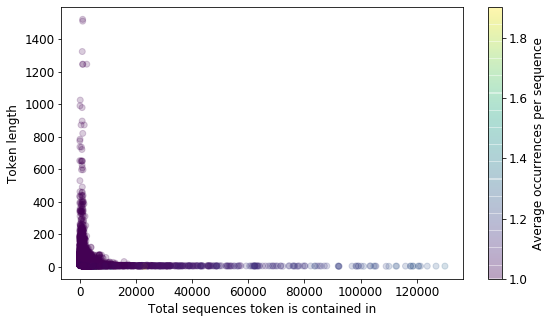

In [101]:
plt.figure(figsize=(9,5))
plt.rc('font', size=12)
plt.scatter(x = token_stats_bpe2['total_seqs_in'], 
            y = token_stats_bpe2['token_length'], 
            c = token_stats_bpe2['avg_occur_in_seq'], 
            alpha = 0.2,
            cmap = 'viridis')
plt.colorbar(label='Average occurrences per sequence')
plt.xlabel('Total sequences token is contained in')
plt.ylabel('Token length')
plt.show()

(2) numbers of clade-specific tokens per taxonomic level

In [108]:
tmp = token_stats_bpe2.groupby('clade_specific_level').size().reset_index(name='counts')
#tmp = tmp.sort_values(by=["counts"])
tmp.set_index('clade_specific_level', inplace = True)
tmp

,counts
clade_specific_level,
1-Species,5
2-Genus,447
3-Family,386
4-Order,487
5-Class,1340
6-Phylum,514
Non-clade-specific,12424


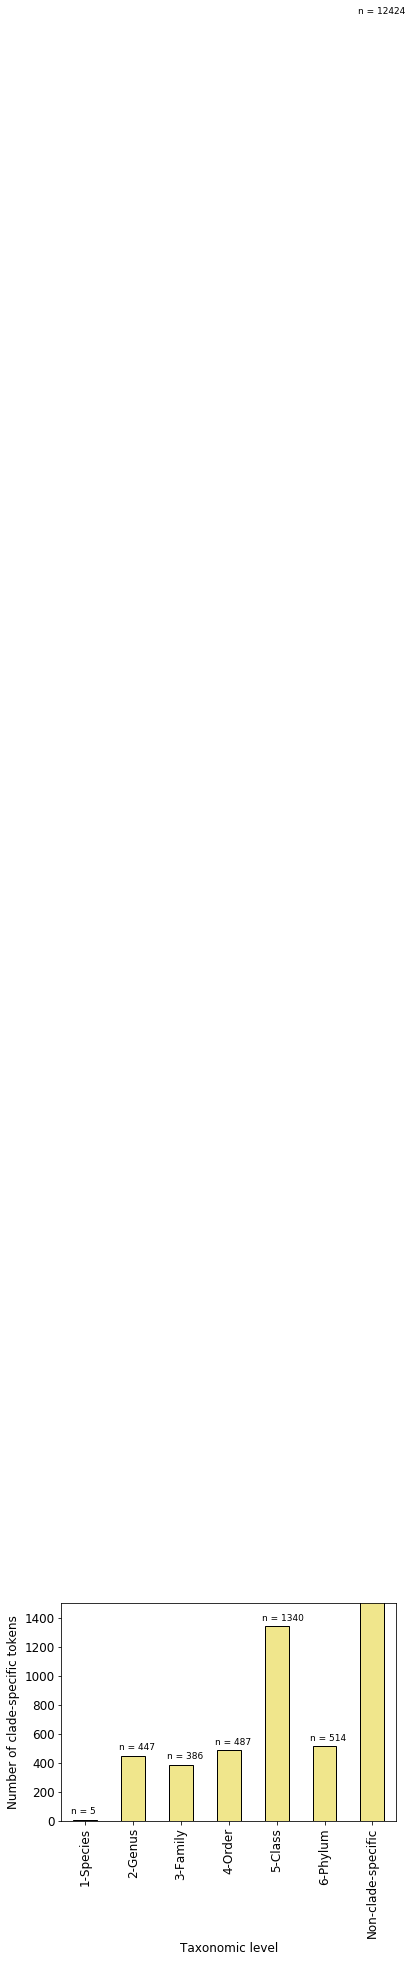

In [109]:
tmp['counts'].plot(kind="bar",  edgecolor='black', color='khaki')
plt.xlabel("Taxonomic level")
plt.ylabel("Number of clade-specific tokens")
plt.ylim(top=1500)

# Create labels
labels = ['n = ' + str(n) for n in tmp.counts]
 
# Text on the top of each barplot
for i in range(len(tmp)):
    plt.text(x = i-0.3 , y = tmp.counts[i]+40, s = labels[i], size = 9)

plt.show()

(3) Clade-specific tokens are longer than other tokens:

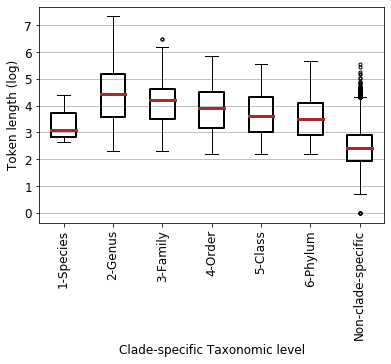

In [135]:
token_stats_bpe2['clade_specific_level'] = token_stats_bpe2['clade_specific_level'].fillna(value='Non-clade-specific')
token_stats_bpe2['token_length_log'] = np.log(token_stats_bpe2['token_length'])
bp = token_stats_bpe2.boxplot(column=['token_length_log'], 
                              by=['clade_specific_level'], 
                              boxprops=dict(linewidth=2),
                              medianprops=dict(linewidth=3),
                              flierprops = dict(markersize=3),
                              color = dict(whiskers='black',caps='black',medians='brown',boxes='black'))
plt.xlabel("Clade-specific Taxonomic level")
plt.ylabel("Token length (log)")
bp.get_figure().suptitle("")
bp.get_figure().gca().set_title("")
plt.xticks(rotation=90)
plt.grid(b=None, axis = 'x')
plt.show()

In [ ]:
### Interesting examples

In [136]:
token_stats_bpe2[token_stats_bpe2['clade_specific_species']]

,token,token_id,token_length,total_appearances_mult_in_seq,total_seqs_in,max_in_single_class,max_in_single_family,max_in_single_genus,max_in_single_order,max_in_single_phylum,...,clade_specific_family,clade_specific_genus,clade_specific_species,clade_specific_phylum,clade_specific_order,clade_specific_strain,clade_specific_any,avg_occur_in_seq,clade_specific_level,token_length_log
3561,agucugcaacucgacuacaugaagcuggaaucgcuaguaaucguag...,11797,80,1186,1186,1142.0,1106.0,1101.0,1112.0,1151.0,...,False,False,True,False,False,False,True,1.0,1-Species,4.382027
4104,auggaggugcauucgaaacugu,12087,22,38,38,38.0,38.0,38.0,38.0,38.0,...,True,True,True,True,True,False,True,1.0,1-Species,3.091042
5308,cagggcgcgacgguagu,12068,17,34,34,34.0,34.0,34.0,34.0,34.0,...,True,True,True,True,True,False,True,1.0,1-Species,2.833213
6872,cgcuagaggaccgc,15338,14,848,848,845.0,845.0,845.0,845.0,846.0,...,True,True,True,True,True,False,True,1.0,1-Species,2.639057
10996,ggaggaagacaccccuauggggcguaaacuccuuuucugaa,12330,41,176,176,176.0,176.0,176.0,176.0,176.0,...,True,True,True,True,True,False,True,1.0,1-Species,3.713572


In [137]:
silva_db.head()

,raw_id,full_taxonomy,seq_length,seq,kingdom,phylum,class,order,family,genus,species,strain
0,HG531388.1.1375,Bacteria;Proteobacteria;Alphaproteobacteria;Rh...,1375,AGUCGAGCGGGCGCAGCAAUGCGUCAGCGGCAGACGGGUGAGUAAC...,Bacteria,Proteobacteria,Alphaproteobacteria,Rhizobiales,Xanthobacteraceae,Rhodoplanes,Rhodoplanes oryzae,NaN
1,HL281785.3.1301,Bacteria;Bacteroidota;Bacteroidia;Bacteroidale...,1299,AUUCCGGGAUAGCCUUUCGAAAGAAAGAUUAAUACUGGAUAGCAUA...,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,unidentified,NaN
2,AB002644.1.1485,Bacteria;Firmicutes;Bacilli;Bacillales;Bacilla...,1485,GGCUAAUACAUGCAAGUCGAGCGAGUGAACAAACAGAAGCCUUCGG...,Bacteria,Firmicutes,Bacilli,Bacillales,Bacillaceae,Bacillus,low G+C Gram-positive bacterium HTA454,NaN
3,AB002648.1.1383,Bacteria;Firmicutes;Bacilli;Thermoactinomyceta...,1383,AGCGGCGAACGGGUGAGUAACACGNGGGUAACCUGCCCUCAAGACC...,Bacteria,Firmicutes,Bacilli,Thermoactinomycetales,Thermoactinomycetaceae,Thermoflavimicrobium,low G+C Gram-positive bacterium HTA1422,NaN
4,JN049459.1.1443,Bacteria;Actinobacteriota;Actinobacteria;Strep...,1443,GACAUGGCGCCUCUACCAUGCAGUCGACGAUGACCACCUUCGGGGU...,Bacteria,Actinobacteriota,Actinobacteria,Streptomycetales,Streptomycetaceae,Streptomyces,actinobacterium ZXY010,NaN


In [172]:
example1 = 'ggaggaagacaccccuauggggcguaaacuccuuuucugaa'
col_idx1 = np.where(np.array(token_strings_bpe) == example1)[0][0]
print(col_idx1)
example1_tok_appears = find(all_encodings_cv_bpe.getcol(col_idx1))

11009


In [173]:
example1_silva_entities = silva_db.iloc[example1_tok_appears[0]]
example1_silva_entities.to_csv(path_or_buf = "C:/Users/efrat/Documents/DNA_BERT_Data/tokens/example2.tsv", sep='\t')

In [174]:
token_stats_bpe2[token_stats_bpe2['clade_specific_genus']]

,token,token_id,token_length,total_appearances_mult_in_seq,total_seqs_in,max_in_single_class,max_in_single_family,max_in_single_genus,max_in_single_order,max_in_single_phylum,...,clade_specific_family,clade_specific_genus,clade_specific_species,clade_specific_phylum,clade_specific_order,clade_specific_strain,clade_specific_any,avg_occur_in_seq,clade_specific_level,token_length_log
24,aaaacuugagugcagaagaggaaaguggaauuccauguguagcggu...,4134,61,1209,1209,1208.0,1203.0,1203.0,1203.0,1209.0,...,True,True,False,True,True,False,True,1.0,2-Genus,4.110874
25,aaaacuugagugcagaagaggaaaguggaauuccauguguagcggu...,5177,339,984,984,984.0,981.0,981.0,981.0,984.0,...,True,True,False,True,True,False,True,1.0,2-Genus,5.826000
26,aaaacuugagugcagaagaggaaaguggaauuccauguguagcggu...,6656,377,588,588,588.0,587.0,587.0,588.0,588.0,...,True,True,False,True,True,False,True,1.0,2-Genus,5.932245
128,aaagcaucagagauggugccccccuugu,9430,28,1587,1587,1585.0,1582.0,1582.0,1582.0,1585.0,...,True,True,False,True,True,False,True,1.0,2-Genus,3.332205
130,aaagcauuagagauagu,14123,17,33,33,33.0,33.0,33.0,33.0,33.0,...,True,True,False,True,True,False,True,1.0,2-Genus,2.833213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15561,uuugugguucaugacuggggugaagucguaacaagguagcgcu,8855,43,23,23,23.0,23.0,23.0,23.0,23.0,...,True,True,False,True,True,False,True,1.0,2-Genus,3.761200
15562,uuugugguucaugacuggggugaagucguaacaagguagcgcuagg...,8953,55,20,20,20.0,20.0,20.0,20.0,20.0,...,True,True,False,True,True,False,True,1.0,2-Genus,4.007333
15563,uuugugguucaugacuggggugaagucguaacaagguagcgcuagg...,9045,60,1683,1683,1683.0,1682.0,1682.0,1682.0,1683.0,...,True,True,False,True,True,False,True,1.0,2-Genus,4.094345
15591,uuuuggauggucccgcggcgu,14451,21,22,22,22.0,22.0,22.0,22.0,22.0,...,True,True,False,True,True,False,True,1.0,2-Genus,3.044522


In [175]:
example2 = 'uuuuggauggucccgcggcguauuagcuagau'
col_idx2 = np.where(np.array(token_strings_bpe) == example2)[0][0]
example2_tok_appears = find(all_encodings_cv_bpe.getcol(col_idx2))
example2_silva_entities = silva_db.iloc[example2_tok_appears[0]]
example2_silva_entities.to_csv(path_or_buf = "C:/Users/efrat/Documents/DNA_BERT_Data/tokens/example2.tsv", sep='\t')

In [180]:
example3 = token_stats_bpe2[token_stats_bpe2['clade_specific_genus']].loc[26, 'token']
example3

'aaaacuugagugcagaagaggaaaguggaauuccauguguagcggugaaaugcgcagagauauggaggaacaccaguggcgaaggcgacuuucuggucuguaacugacgcugaugugcgaaagcguggggaucaaacaggauuagauacccugguaguccacgccguaaacgaugagugcuaaguguuaggggguuuccgccccuuagugcugcagcuaacgcauuaagcacuccgccuggggaguacgaccgcaagguugaaacucaaaggaauugacggggacccgcacaagcgguggagcaugugguuuaauucgaagcaacgcgaagaaccuuaccaaaucuugacauccuuugacaacucuagagauagagc'

In [181]:
col_idx3 = np.where(np.array(token_strings_bpe) == example3)[0][0]
example3_tok_appears = find(all_encodings_cv_bpe.getcol(col_idx3))
example3_silva_entities = silva_db.iloc[example3_tok_appears[0]]
example3_silva_entities.to_csv(path_or_buf = "C:/Users/efrat/Documents/DNA_BERT_Data/tokens/example3.tsv", sep='\t')

In [185]:
token_stats_bpe2[(token_stats_bpe2['clade_specific_any']) & (token_stats_bpe2['total_seqs_in'] < 100) & (token_stats_bpe2['token_length'] > 300)]

,token,token_id,token_length,total_appearances_mult_in_seq,total_seqs_in,max_in_single_class,max_in_single_family,max_in_single_genus,max_in_single_order,max_in_single_phylum,...,clade_specific_family,clade_specific_genus,clade_specific_species,clade_specific_phylum,clade_specific_order,clade_specific_strain,clade_specific_any,avg_occur_in_seq,clade_specific_level,token_length_log
2087,agaguggaauuccacguguagcggugaaaugcguagauauguggag...,12119,345,35,35,35.0,35.0,35.0,35.0,35.0,...,True,True,False,True,True,False,True,1.0,2-Genus,5.843544
2088,agaguggaauuccacguguagcggugaaaugcguagauauguggag...,12393,529,83,83,83.0,83.0,83.0,83.0,83.0,...,True,True,False,True,True,False,True,1.0,2-Genus,6.270988
2156,agaguuugauccuggcucagauugaacgcuggcgggaugcuuuaca...,12170,737,79,79,79.0,79.0,79.0,79.0,79.0,...,True,True,False,True,True,False,True,1.0,2-Genus,6.602588
3856,aucaucaugccccuuaugaccugggcuacacacgugcuacaaugga...,13413,334,89,89,89.0,89.0,89.0,89.0,89.0,...,True,True,False,True,True,False,True,1.0,2-Genus,5.811141
4129,augggagaggaugguagaauuccagguguagcggugaaaugcguag...,14102,388,94,94,94.0,94.0,94.0,94.0,94.0,...,True,True,False,True,True,False,True,1.0,2-Genus,5.961005
4779,caaggcaacgaugcauagccgaccugagagggugaucggccacacu...,11859,396,64,64,64.0,64.0,64.0,64.0,64.0,...,True,True,False,True,True,False,True,1.0,2-Genus,5.981414
6506,cgaguggcgaacgggugaguaauguaucggaacgugcccaguagcg...,12085,652,10,10,10.0,10.0,10.0,10.0,10.0,...,True,True,False,True,True,False,True,1.0,2-Genus,6.480045
12465,gguuucggcuaucgcuuacagaugggcccgcggugcauuagcuagu...,12363,461,86,86,86.0,86.0,86.0,86.0,86.0,...,True,True,False,True,True,False,True,1.0,2-Genus,6.133398
12675,gucaacuagcuguuggggccuucgggccuugguagcgcagcuaacg...,12206,434,10,10,10.0,10.0,5.0,10.0,10.0,...,True,False,False,True,True,False,True,1.0,3-Family,6.073045
14671,ugacgcucaugcacgaaaguguggggagcaaacaggauuagauacc...,12373,774,52,52,52.0,52.0,52.0,52.0,52.0,...,True,True,False,True,True,False,True,1.0,2-Genus,6.651572


In [187]:
example4 = token_stats_bpe2[token_stats_bpe2['clade_specific_genus']].loc[6506, 'token']
print(example4)
col_idx4 = np.where(np.array(token_strings_bpe) == example4)[0][0]
example4_tok_appears = find(all_encodings_cv_bpe.getcol(col_idx4))
example4_silva_entities = silva_db.iloc[example4_tok_appears[0]]
example4_silva_entities.to_csv(path_or_buf = "C:/Users/efrat/Documents/DNA_BERT_Data/tokens/example4.tsv", sep='\t')

cgaguggcgaacgggugaguaauguaucggaacgugcccaguagcgggggauaacuacgcgaaagcguggcuaauaccgcauacgcccuacgggggaaagcgggggaccuucgggccucgcacuauuggagcggccgauaucggauuagcuaguuggugggguaacggccuaccaaggcgacgauccguagcugguuugagaggacgaccagccacacugggacugagacacggcccagacuccuacgggaggcagcaguggggaauuuuggacaaugggggcaacccugauccagccaucccgcgugugcgaugaaggccuucggguuguaaagcacuuuuggcaggaaagaaacggcacgggcuaauauccugugcaacugacgguaccugcagaauaagcaccggcuaacuacgugccagcagccgcgguaauacguagggugcaagcguuaaucggaauuacugggcguaaagcgugcgcaggcgguucggaaagaaagaugugaaaucccagggcuuaaccuuggaacugcauuuuuaacuaccgggcuagagugugucagagggagguggaauuccgcguguagcagugaaaugcguagauaugcggaggaacaccgauggcgaaggcagccuccugggauaacac


In [188]:
silva_db[silva_db['genus'] == 'Bordetella']

,raw_id,full_taxonomy,seq_length,seq,kingdom,phylum,class,order,family,genus,species,strain
1696,JN208922.1.1403,Bacteria;Proteobacteria;Gammaproteobacteria;Bu...,1403,UGAUCCUGGCUCAGAUUGAACGCUAGCGGGAUGCUUUACACAUGCA...,Bacteria,Proteobacteria,Gammaproteobacteria,Burkholderiales,Alcaligenaceae,Bordetella,Bordetella sp. SPB-24,NaN
2823,AJ249861.1.1496,Bacteria;Proteobacteria;Gammaproteobacteria;Bu...,1485,CGCUAGCGGGAUGCUUUACACAUGCAAGUCGAACGGCAGCGCGGAC...,Bacteria,Proteobacteria,Gammaproteobacteria,Burkholderiales,Alcaligenaceae,Bordetella,Bordetella petrii,NaN
3519,AJ277798.1.1521,Bacteria;Proteobacteria;Gammaproteobacteria;Bu...,1509,AGAGUUUGAUCCUGGCUCAGAUUGAACGCUGGCGGGAUGCUUUACA...,Bacteria,Proteobacteria,Gammaproteobacteria,Burkholderiales,Alcaligenaceae,Bordetella,Bordetella trematum,NaN
3524,AJ278452.1.1523,Bacteria;Proteobacteria;Gammaproteobacteria;Bu...,1511,AGAGUUUGAUCAUGGCUCAGAUUGAACGCUGGCGGGAUGCUUUACA...,Bacteria,Proteobacteria,Gammaproteobacteria,Burkholderiales,Alcaligenaceae,Bordetella,Bordetella bronchiseptica,NaN
3863,AJ278450.1.1523,Bacteria;Proteobacteria;Gammaproteobacteria;Bu...,1511,AGAGUUUGAUCCUGGCUCAGAUUGAACGCUGGCGGGAUGCUUUACA...,Bacteria,Proteobacteria,Gammaproteobacteria,Burkholderiales,Alcaligenaceae,Bordetella,Bordetella parapertussis,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
413550,CP031788.2315176.2316695,Bacteria;Proteobacteria;Gammaproteobacteria;Bu...,1520,AGAGUUUGAUCCUGGCUCAGAUUGAACGCUGGCGGGAUGCUUUACA...,Bacteria,Proteobacteria,Gammaproteobacteria,Burkholderiales,Alcaligenaceae,Bordetella,Bordetella pertussis,NaN
417157,JWLA01000001.591134.592512,Bacteria;Proteobacteria;Gammaproteobacteria;Bu...,1321,GGGGAAAGCGGGGGACCUUCGGGCCUCGCACUAUUGGAGCGGCCGA...,Bacteria,Proteobacteria,Gammaproteobacteria,Burkholderiales,Alcaligenaceae,Bordetella,Bordetella pertussis,NaN
417283,DQ288113.1.1430,Bacteria;Proteobacteria;Gammaproteobacteria;Bu...,1430,UAGGGUUAUUGUUUUUCUAUGCAAGUCGAACGGCAGCGCGGACUUC...,Bacteria,Proteobacteria,Gammaproteobacteria,Burkholderiales,Alcaligenaceae,Bordetella,Bordetella sp. QJ7-8,NaN
420343,JDFP01000008.681.2197,Bacteria;Proteobacteria;Gammaproteobacteria;Bu...,1509,AGAGUUUGAUCCUGCGCUCAGAUUGAACGCUGCGCGGAUGCUUUAC...,Bacteria,Proteobacteria,Gammaproteobacteria,Burkholderiales,Alcaligenaceae,Bordetella,Bordetella holmesii 30539,NaN
